In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from minlora import add_lora, apply_to_lora, disable_lora, enable_lora, get_lora_params, merge_lora, name_is_lora, remove_lora, load_multiple_lora, select_lora

from sklearn.decomposition import PCA

In [2]:
embeddings = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/MoNA_embeddings_multiple_instrument_types.csv')
spectra = pd.read_csv('/home/cmdunham/mass_spec/mass_spec_repo/data/scaled_spectra_with_instrument_type.csv')

In [3]:
def plot_emb_pca(all_embeddings, output_embeddings, output_labels):
  """
  Run pca on embeddings from denoiser output. Plot results against pca of Chemception embeddings.

  Args:
  - all_embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - output_embeddings: (list) Encoder output embeddings.
  - output_labels: (list) Chemical names for each embedding in the encoder's output.
  """

  pca = PCA(n_components=2)
  pca.fit(all_embeddings.T)

  unique_labels = sorted(list(set(output_labels)))
  embeddings_subset = [all_embeddings[chem] for chem in unique_labels]
  true_transformed = pca.transform(embeddings_subset)

  output_transformed = pca.transform(output_embeddings)

  color_map = {chem: idx for idx, chem in enumerate(unique_labels)}

  # Map labels to colors for both true and output embeddings
  true_colors = [color_map[chem] for chem in unique_labels]
  output_colors = [color_map[chem] for chem in output_labels]

  true_x = [pair[0] for pair in true_transformed]
  true_y = [pair[1] for pair in true_transformed]
  scatter = plt.scatter(true_x, true_y, c=true_colors,
                        cmap='tab20')

  output_x = [pair[0] for pair in output_transformed]
  output_y = [pair[1] for pair in output_transformed]
  plt.scatter(output_x, output_y, marker='x', c=output_colors, cmap='tab20')

  plt.legend(handles=scatter.legend_elements()[0],
              labels=unique_labels,
              loc='upper right',
              prop={'size':7})


  plt.title('Chemception Embeddings vs. Denoiser Output')
  plt.xticks([])
  plt.yticks([])

  plt.show()

In [4]:
def plot_results(real_spectra, fake_spectra, labels, idx=[0,10], window=300, cutoff = 0):

  for i, (real_spec, fake_spec) in enumerate(zip(real_spectra, fake_spectra)):
    # only plotting spectra within the specified idx range
    if i > idx[1]:
      break
    if idx[0] <= i < idx[1]:

      numbers = range(0,window)
      input_frequencies = real_spec.copy()

      out_clone = fake_spec.copy()
      out_frequencies = [0 if num < cutoff else num for num in out_clone]

      fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, sharey=True, figsize=(20, 10))

      ax[0].bar(numbers, input_frequencies[:window])
      ax[0].set_title(f'Real {labels[i]} Spectrum.', fontsize=18)
      ax[0].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[0].set_ylabel('Intensity', fontsize=16)

      ax[1].bar(numbers, out_frequencies[:window])
      ax[1].set_title(f'Synthetic {labels[i]} Spectrum.', fontsize=18)
      ax[1].set_xlabel('Mass to Charge Ratio', fontsize=16)
      ax[1].set_ylabel('Intensity', fontsize=16)

      plt.tight_layout()
      plt.show()

In [5]:
def create_dataset_sections(spectra, embeddings, columns, batch_size=32, noise_loc = None, noise_pct = None):
  
    """
    Given a list of column names, return a DataLoader object with data for those columns

    Args:
    - spectra (pd.DataFrame): Mass spec data with observations as columns.
    - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
    - columns (list): Column names to be included in the dataset 
    - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings' or 'conditions'
    - noise_pct (float): percent of noise to introduce to target location
    
    Returns:
    - input_data (DataLoader object): spectrum, encoding information and embedding, labels - chem names
    """
    input_list = []
    true_list = []

    # create lists of spectrum data, condition encoding and chemception embedding with noise as specified in the noise_loc argument
    labels = []

    spectrum_data = spectra[list(columns)][:915].values.copy()
    true_list.append(spectrum_data)
    input_spectra = spectrum_data.copy()
    # generate a list of random indices of len = noise_pct% of target location and change values at each index to a random number
    if noise_loc == 'spectra':
        for spec in input_spectra:
            noise = noise_pct * len(spec)
            random_numbers = random.sample(range(len(spec)), int(round(noise)))
            for i in random_numbers:
                spec[i] = random.random()
    input_list.append(input_spectra)

    condition_encodings = spectra[list(columns)][-12:].values.copy()
    true_list.append(condition_encodings)
    input_condition = condition_encodings.copy()
    if noise_loc == 'conditions':
        for cond in input_condition:
            noise = noise_pct * len(cond)
            random_numbers = random.sample(range(len(cond)), int(round(noise)))
            for i in random_numbers:
                cond[i] = random.random()
    input_list.append(input_condition)

    true_embeddings = []
    input_embeddings = []
    for col in columns:
        input_embedding = embeddings[col.split('.')[0]].copy()
        true_embeddings.append(embeddings[col.split('.')[0]].copy())
        if noise_loc == 'embeddings':
            noise = noise_pct * len(input_embedding)
            random_numbers = random.sample(range(len(input_embedding)), int(round(noise)))
            for i in random_numbers:
                input_embedding[i] = random.random()
        input_embeddings.append(input_embedding)
        # label is chemical name encoding
        labels.append(list(spectra[col][915:-12]))
    
    true_list.append(torch.tensor(true_embeddings).T)
    input_list.append(torch.tensor(input_embeddings).T)

    labels = torch.tensor(labels, dtype=torch.float)

    input_data = torch.tensor(np.vstack((input_list)).T, dtype=torch.float)
    # input_data = nn.functional.normalize(input_data)
    all_true_vals = torch.tensor(np.vstack((true_list)).T, dtype=torch.float)
    all_data = torch.cat((input_data.unsqueeze(0), all_true_vals.unsqueeze(0)), dim=0)
    # normalized_data = nn.functional.normalize(all_data)
    # input_data = normalized_data[0]
    # all_true_vals = normalized_data[1]
    # all_true_vals = nn.functional.normalize(all_true_vals)
    input_data = TensorDataset(input_data, all_true_vals, labels)

    # each batch of the dataset has three parts: noisy input data, clean data for comparison, chemical name encodings
    input_data = DataLoader(dataset=input_data, batch_size=batch_size, shuffle=True)

    return input_data

In [6]:
# train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc='embeddings', noise_pct=0)

In [7]:
def create_dataset(spectra, embeddings, test_chem = 'Succinic Acid', instrument_idx = 8, batch_size=32, training_chems = None, noise_loc = None, noise_pct = None):
  """
  Args:
  - spectra (pd.DataFrame): Mass spec data with observations as columns.
  - embeddings (pd.DataFrame): Column headers are chemical names. Each column represents one chemical's Chemception embedding.
  - instrument_idx (int): Encoded index of instrument to be set aside for testing
  - batch_size (int): Batch size to use for training
  - training_chems (list): When training small group models this param can be used to specify which chems to include in the dataset
  - noise_loc (str): Location for noise in the dataset - 'spectra', 'embeddings', 'conditions' or None
  - noise_pct (float): percent of noise to introduce to target location

  Returns:
    Tuple:
    - train_input (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - test_input (DataLoader object): spectrum, encoding information and embedding, with noise in specified location, labels - chem names
  """

  if noise_loc not in ['spectra', 'embeddings', 'conditions', None]:
    raise ValueError("Invalid value for 'noise_loc'. Please choose from 'spectra', 'embeddings', 'conditions', or None.")
  
  all_test_chem_columns = [col for col in spectra.columns if test_chem in col]

  # separate specified chemical and instrument type for testing  
  test_cols = []
  for col in all_test_chem_columns:
    instrument_encoding = list(spectra[col][-12:])
    # filter out the test instrument type
    if instrument_encoding.index(1) == instrument_idx:
      test_cols.append(col)

  # use either specified chemicals (for small group training) or everything except test cols for training data
  non_test_cols = set(spectra.columns) - set(test_cols)
  if training_chems:
    train_cols = [col for col in non_test_cols if col.split('.')[0] in training_chems]
  else:
    train_cols = non_test_cols

  train_input = create_dataset_sections(spectra, embeddings, train_cols, batch_size=batch_size, noise_loc=noise_loc, noise_pct=noise_pct)
  test_input = create_dataset_sections(spectra, embeddings, test_cols, batch_size=batch_size, noise_loc=None)

  return train_input, test_input

In [35]:
class Denoiser(nn.Module):
  def __init__(self):
    super().__init__()

    self.denoiser = nn.Sequential(
      nn.Linear(1439,1389),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1389,1339),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1339,1289),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1289,1339),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1339, 1389),
      nn.LeakyReLU(inplace=True),
      nn.Linear(1389, 1439),
    )

    self.optimizer = torch.optim.Adam(self.parameters(), lr = .0001)
    self.criterion = nn.MSELoss()

  def forward(self, x):
    x = self.denoiser(x)
    return x

In [41]:
def train_denoiser(model, data, sorted_chemical_names, epochs, loss_type):
    """
    Args:
    - model (Denoiser): Instantiated Denoiser model.
    - data (DataLoader object): spectrum, encoding information and embeddings, with noise in specified location, labels - chem names
    - sorted_chemical_names (list): Sorted list of all chemical names in the training data.
    - epochs (int): Number of epochs to train for.
    - loss_type (str): One of: 'spectra', 'condition' or 'embnedding'

    Returns:
    - model_output (list): Training data with noisy areas filled in.
    - output_labels (list): Chemical name labels for training data. 
    - true_vals_output (list): Original training data without noise
    """

    if loss_type not in ['spectra', 'embedding', 'condition', None]:
        raise ValueError("Invalid value for 'loss_type'. Please choose from 'spectra', 'embedding', 'condition'")

    model_output = []
    output_labels = []
    true_vals_output = []
    for epoch in range(epochs):
        # accumulate epoch output and loss
        epoch_training_loss = 0
        for batch, true_vals, labels in data:
            output = model(batch)
            # loss = model.criterion(output, true_vals)
            # loss = spectra_loss
            # loss =  .05 * spectra_loss + .1 * condition_loss + embedding_loss
            if loss_type == 'spectra':
                output_spectra = output[:, :915]
                true_spectra = true_vals[:,:915]
                loss = model.criterion(output_spectra, true_spectra)
                # loss = spectra_loss
            if loss_type == 'condition':
                output_conditions = output[:, 915:927]
                true_conditions = true_vals[:, 915:927]
                loss = model.criterion(output_conditions, true_conditions)
                # loss=condition_loss
            if loss_type == 'embedding':
                output_embeddings = output[:, 927:]
                true_embeddings = true_vals[:, 927:]
                loss = model.criterion(output_embeddings, true_embeddings)
                # loss = embedding_loss
            epoch_training_loss += loss

            # back propogation
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()

            if (epoch+1)==epochs:
                chem_names = [sorted_chemical_names[list(encoding).index(1)] for encoding in labels]
                for denoised_vector, chem_name, true_val in zip(output, chem_names, true_vals):
                    model_output.append(denoised_vector)
                    true_vals_output.append(true_val)
                    output_labels.append(chem_name)

        average_loss = epoch_training_loss/len(data)
        if (epoch+1) % 10 == 0:
            print('Epoch[{}/{}], loss: {}'.format(epoch+1, epochs, average_loss))

    return model_output, output_labels, true_vals_output

In [10]:
# create sorted list of all chemical names in the dataset
all_chemical_names = []
for col in spectra:
    chem = col.split('.')[0]
    if chem not in all_chemical_names:
        all_chemical_names.append(chem)

all_chemical_names = sorted(all_chemical_names)

In [11]:
train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc='embeddings', noise_pct=1)

In [42]:
# train_noisy_embedding, test_noisy_embedding = create_dataset(spectra, embeddings, noise_loc='embeddings', noise_pct=1)
denoiser = Denoiser()
model_output, output_labels, true_values = train_denoiser(denoiser, train_noisy_embedding, all_chemical_names, epochs=100, loss_type='embedding')

Epoch[10/100], loss: 0.003498125821352005
Epoch[20/100], loss: 0.0008153987000696361
Epoch[30/100], loss: 0.0002608965151011944
Epoch[40/100], loss: 0.00015558073937427253
Epoch[50/100], loss: 0.0001452249416615814
Epoch[60/100], loss: 9.216598118655384e-05
Epoch[70/100], loss: 0.00010751403169706464
Epoch[80/100], loss: 0.00012100770982215181
Epoch[90/100], loss: 0.00025188789004459977
Epoch[100/100], loss: 0.00010689684859244153


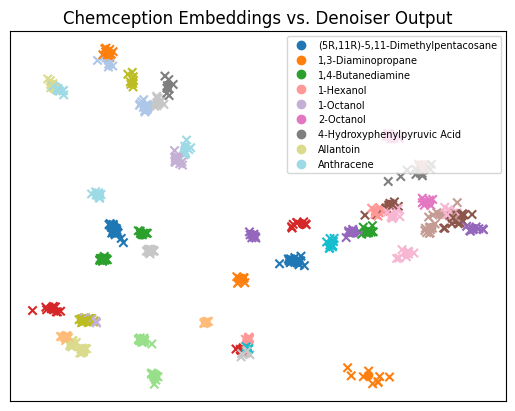

In [43]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels)

In [45]:
denoiser.optimizer = torch.optim.AdamW(denoiser.parameters(), lr=.00001)
model_output, output_labels, true_values = train_denoiser(denoiser, train_noisy_embedding, all_chemical_names, epochs=100, loss_type='embedding')

Epoch[10/100], loss: 1.7247592040803283e-05
Epoch[20/100], loss: 1.2516516108007636e-05
Epoch[30/100], loss: 1.0087942428071983e-05
Epoch[40/100], loss: 8.741609235585202e-06
Epoch[50/100], loss: 8.032598998397589e-06
Epoch[60/100], loss: 7.632639608345926e-06
Epoch[70/100], loss: 5.724297352571739e-06
Epoch[80/100], loss: 5.6413168749713805e-06
Epoch[90/100], loss: 8.423112376476638e-06
Epoch[100/100], loss: 4.865226856054505e-06


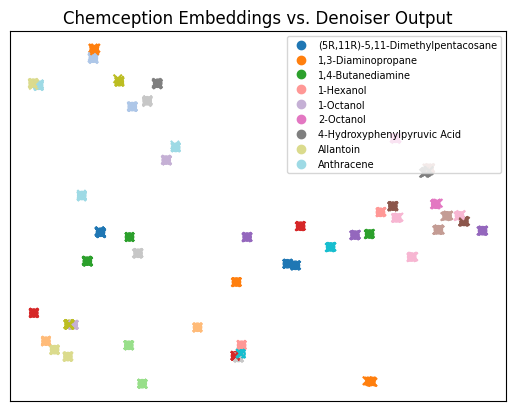

In [46]:
output_embeddings = [vec[-512:].detach().numpy() for vec in model_output]
plot_emb_pca(embeddings, output_embeddings, output_labels)

In [47]:
denoiser_path = '/home/cmdunham/mass_spec/mass_spec_repo/models/denoiser_fine_tuned.pth'
torch.save(denoiser.state_dict(), denoiser_path)

In [57]:
denoiser = Denoiser()

denoiser.load_state_dict(torch.load(denoiser_path))

# add LoRA to denoiser
add_lora(denoiser)

# collect params and pass to optimizer
parameters = [{"params":list(get_lora_params(denoiser))}]
denoiser.optimizer = torch.optim.AdamW(parameters, lr=.0001)

model_output, output_labels, true_values = train_denoiser(denoiser, train_noisy_embedding, all_chemical_names, epochs=10, loss_type='embedding')

# export LoRA params
state_dict = denoiser.state_dict()
lora_state_dict = {k:v for k, v in state_dict.items() if name_is_lora(k)}

# merge LoRA params into denoiser
_ = denoiser.load_state_dict(lora_state_dict, strict=False)
merge_lora(denoiser)

Epoch[10/10], loss: 3.1944407510309247e-06


In [58]:
train_noisy_spectra, test_noisy_spectra = create_dataset(spectra, embeddings, noise_loc='spectra', noise_pct=1)

In [55]:
denoiser = Denoiser()

denoiser.load_state_dict(torch.load(denoiser_path))
model_output, output_labels, true_values = train_denoiser(denoiser, train_noisy_spectra, all_chemical_names, epochs=10, loss_type='spectra')

Epoch[10/10], loss: 0.00021825557632837445
